## Prepare data set from survey data for the choice model
Based on Graham (2020) and Joon (2025, https://github.com/krisjuune/cantonal-preferences-s2z/)

### Load libraries

In [2]:
import pandas as pd
import numpy as np
import os
import re
import importlib
import f_data_processing as dp
import map_data as md

dp = importlib.reload(dp)
md = importlib.reload(md)
print(os.getcwd())


c:\Users\stdt\ETH Zurich\PhD Veronika - 07_Master Thesis Natalie\10_hcm_code\natural_hazard_solidarity


### Read surveys and do first filtering

Define the data file paths to the survey-data as dictionary. In the dictionary you can always add more datasets to merge (i.e. after another survey round S2).


In [3]:
survey_dict = {'S0': '../data/Survey_Adaptation Natural Hazards_First Wave_raw data.csv', 
               'S1': '../data/Survey_Adaptation Natural Hazards_Second Wave_raw data.csv'}

Loop through the dictionary and apply filtering and cleansing and type conversion. The following steps are done:

1. Read csv-file and clean column names for trailing spaces, dots, and naming as well as change cell values to numeric for the necessary id-columns.
2. Remove entries that are not complete.
3. Filter out speedies and slowies, and inattentives.
4. Transform needed likert/numeric columns (defined in `map_data.py`) into numeric columns.
5. Transform needed non-numeric cells to numeric value.
6. Translate choice experiment replies (choice descriptions) to english.
7. Drop additional responses where more than two have been done using the same IPA-address.
8. Delete unecessary or unanonymos columns.
9. Add prefix to every column name so the different survey can be merged.


In [4]:
df_dict ={}

# language region is kept to analyze eventual cultural differences within Switzerland

for s, file in survey_dict.items():
    df = pd.read_csv(file, dtype={'id': 'string'}, skiprows=[1,2])
    # remove lines, replace empty cells, rename columnames
    df = df.replace('', pd.NA)
    df.columns = df.columns.str.replace('.', '', regex=False)
    df.columns = df.columns.str.replace(r'\s+', '', regex=True)
    df = dp.rename_columns(df, 'municipality', 'benefits')
    df = dp.to_num_col(df, ['id', 'm'])

    # filter only complete/valid response rows
    df = df[(df['DistributionChannel'] != 'preview') & (df['Finished'] != False)].copy()
    df = df[~df['Q_TerminateFlag'].isin(['PoorQuality', 'NA', 'QuotaMet', 'Screened'])].copy()
    
    # Exclude speeders, straightliners, inattentives
    speedy_slowy = dp.rm_speeders(df)
    straightliners = dp.rm_straightliners(df)
    inattentives = df[f'attention_check'] != 'Agree'
    df_filtered = df[~((speedy_slowy | straightliners | inattentives))]
    df_filtered = df_filtered.copy()
    
    # transform liker/numeric scales, non-numeric columns
    if s == 'S0':
        df_filtered[md.NUM_COLUMNS] = df_filtered[md.NUM_COLUMNS].apply(pd.to_numeric, errors="coerce")
    df_filtered = dp.string_mapping(df_filtered, md.LIKERT_MAP, md.VALID_COLUMNS, numeric=True)
    df_filtered = dp.string_mapping(df_filtered, md.LIKERT_MAP, ['climatechange_nh_1'], numeric=True)
    df_filtered = dp.string_mapping(df_filtered, md.NH_EXPERIENCE_MAP,['experience_nh'],numeric=True)
    
    # invert likert scales for consistency
    dp.invert_likert(df_filtered, ['finan_vulnerability_1'], 6)
    
    # remove double ipas
    df_filtered = dp.filter_double_ipa(df_filtered)
    
    pattern = '|'.join(map(re.escape, md.ANONYMIZE_COLS))
    columns = df_filtered.filter(regex=pattern)
    df_filtered = df_filtered.drop(columns=df_filtered.filter(regex=pattern).columns)
    
    # prepare for merging
    df_filtered = df_filtered.add_prefix(f'{s}_')
    df_dict[s] = df_filtered
    df_filtered.to_csv(f'../results/{s}_clean_survey.csv')
    print(len(df_filtered))
    
df_filtered


Duration: min  150  max  21320
Fastest and slowest 10% (Total): 118 respondents (<366.8s or >2754.999999999999s)
942
Duration: min  288  max  10870
Fastest and slowest 10% (Total): 60 respondents (<475.55s or >3196.1000000000004s)
509


,S1_StartDate,S1_EndDate,S1_Progress,S1_duration,S1_Finished,S1_knowledge_nh_1,S1_knowledge_nh_2,S1_knowledge_nh_3,S1_sensitivity_nh_1,S1_sensitivity_nh_2,...,S1_choice9_costs1,S1_choice9_costs2,S1_choice9_exemptions1,S1_choice9_exemptions2,S1_choice9_benefits1,S1_choice9_benefits2,S1_Q_TerminateFlag,S1_Q_R_Del,S1_screened_out,S1_SelectedLanguage
0,2025-08-30 16:55:44,2025-08-30 17:06:19,100,635,True,Yes,Yes,Yes,1.0,1.0,...,Tous les citoyens paient le même montant,Les personnes paient proportionnellement à leu...,Les personnes à faibles et moyens revenus peuv...,Les personnes à faibles et moyens revenus peuv...,Municipalités ayant une grande valeur culturel...,Niveaux de protection égaux pour toutes les mu...,Complete,NaN,False,FR
1,2025-08-30 16:55:45,2025-08-30 17:09:24,100,818,True,Yes,No,Yes,6.0,6.0,...,Les entreprises paient proportionnellement à l...,Tous les citoyens paient le même montant,Aucun groupe n'est exempté des coûts,Aucun groupe n'est exempté des coûts,Les municipalités les plus touchées par les ri...,Niveaux de protection égaux pour toutes les mu...,Complete,NaN,False,FR
2,2025-08-30 16:55:27,2025-08-30 17:09:25,100,837,True,Yes,Yes,Yes,2.0,2.0,...,Tous les citoyens paient le même montant,Les entreprises paient proportionnellement à l...,Les personnes à faible revenu peuvent être exe...,Aucun groupe n'est exempté des coûts,Municipalités ayant une grande valeur culturel...,Les municipalités économiquement prospères,Complete,NaN,False,FR
3,2025-08-30 16:56:35,2025-08-30 17:11:53,100,917,True,Yes,Yes,Yes,1.0,1.0,...,Les entreprises paient proportionnellement à l...,Les entreprises paient proportionnellement à l...,Aucun groupe n'est exempté des coûts,Aucun groupe n'est exempté des coûts,Les municipalités les plus touchées par les ri...,Les municipalités économiquement prospères,Complete,NaN,False,FR
4,2025-08-30 17:02:18,2025-08-30 17:13:04,100,645,True,Yes,Yes,Yes,3.0,4.0,...,"Menschen und Unternehmen, die von Schutzmaßnah...","Menschen und Unternehmen, die von Schutzmaßnah...",Keine Gruppen sind von den Kosten ausgenommen,mit Ausnahme von Menschen mit niedrigem Einkommen,Gemeinden mit vielen Kulturgütern wie z.B. his...,Gemeinden mit vielen Kulturgütern wie z.B. his...,Complete,NaN,False,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2025-09-12 12:49:21,2025-09-12 13:09:29,100,1208,True,Yes,Yes,Yes,5.0,5.0,...,Unternehmen zahlen proportional zu ihrem CO2-A...,Alle Menschen zahlen den gleichen Betrag,Keine Gruppen sind von den Kosten ausgenommen,mit Ausnahme von Menschen mit niedrigem Einkommen,"Gemeinden, in denen Menschen seit vielen Jahre...",Wirtschaftlich wohlhabende Gemeinden,Complete,NaN,False,DE
505,2025-09-12 13:06:28,2025-09-12 13:29:18,100,1369,True,Yes,Yes,Yes,1.0,3.0,...,Menschen zahlen proportional zu ihrem CO2-Auss...,Alle Menschen zahlen den gleichen Betrag,mit Ausnahme von Menschen mit niedrigem und mi...,Keine Gruppen sind von den Kosten ausgenommen,Gleiche Schutzniveaus für alle Gemeinden,Wirtschaftlich wohlhabende Gemeinden,Complete,NaN,False,DE
506,2025-09-12 18:23:30,2025-09-12 18:36:10,100,759,True,Yes,Yes,Yes,4.0,5.0,...,Menschen zahlen proportional zu ihrem CO2-Auss...,Menschen zahlen proportional zu ihrem Einkommen,Keine Gruppen sind von den Kosten ausgenommen,mit Ausnahme von Menschen mit niedrigem Einkommen,Gemeinden mit vielen Kulturgütern wie z.B. his...,"Gemeinden, in denen Menschen seit vielen Jahre...",Complete,NaN,False,DE
507,2025-09-13 11:21:48,2025-09-13 11:34:14,100,746,True,Yes,Yes,Yes,2.0,3.0,...,Les personnes paient proportionnellement à leu...,Les personnes et entreprises bénéficiant des m...,Aucun groupe n'est exempté des coûts,Aucun groupe n'est exempté des coûts,Municipalités ayant une grande valeur culturel...,Les municipalités économiquement prospères,Complete,NaN,False,FR


### Merging and cleanup
Merge the datasets on the user id so only respondents are kept that filled out both survey. This makes it possible to analyze the change in preference related to a natural hazard occurence (Blatten).
Afterwards the remaining answers are all standardized by translating answers to English.

In [5]:
# merge both surveys and check for uniqueness
# here you can always add more dataframes to merge (i.e. after another survey round S2)
merged_waves_df = (
    md.KEYS
    .merge(df_dict['S0'], how='inner', left_on='S0_idx', right_on='S0_id')
    .merge(df_dict['S1'], how='inner', left_on='S1_idx', right_on='S1_m')
    .drop(columns=['S0_id', 'S0_m', 'S1_id', 'S1_m'])
)

print(len(merged_waves_df))

# drop non-unique rows and reset unique ids
df_cleaned = merged_waves_df.drop_duplicates(subset=['S0_idx', 'S1_idx'], keep='first')
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned['respondent_id'] = df_cleaned.index + 1

# map demographics and translate choice options
df_cleaned = dp.string_mapping(df_cleaned, md.DEMOGRAPHICS_DICT, column_patterns=[r'_gender$', r'_age$', r'_education$', r'_income$', r'_language$', r'_language_region$', r'_party_choice$'])
df_cleaned = dp.string_mapping(df_cleaned, md.TRANSLATION_DICT, column_patterns=[r'^S._choice._exemptions', r'^S._choice._costs', r'^S._choice._benefits'])


df_cleaned['S0_income']

504


c:\Users\stdt\ETH Zurich\PhD Veronika - 07_Master Thesis Natalie\10_hcm_code\natural_hazard_solidarity\f_data_processing.py:168: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace(mapping_dict)


0      NaN
1      3.0
2      2.0
3      3.0
4      2.0
      ... 
498    3.0
499    2.0
500    2.0
501    3.0
502    3.0
Name: S0_income, Length: 503, dtype: float64

After merging the survey data sets:
> This leaves us with TODO 503 respondes that filled out both surveys

In [6]:
df_cleaned.to_csv('../results/combined_surveys.csv')
df_cleaned['S0_income']

0      NaN
1      3.0
2      2.0
3      3.0
4      2.0
      ... 
498    3.0
499    2.0
500    2.0
501    3.0
502    3.0
Name: S0_income, Length: 503, dtype: float64

### Prepare conjoint data set 

Select all columns to be used in the conjoint analysis:
- The columns describing the conjoint options ```z``` 1 and 2 presented to the respondent per task ```y``` per survey ```x```.
- The chosen option for each task ```y``` per survey ```x```.
- As well as the unique ```respondent_id``` over the two surveys.

In [7]:
# select conjoint option columns for cost, benefit, and exemption
attr_pattern = r'^S\d+_choice\d+_(costs|benefits|exemptions)\d+$'
attr_cols = df_cleaned.filter(regex=attr_pattern).columns

# select conjoint choice columns
choice_pattern = r'^S\d+_\d+_conjoint_prefer$'
choice_cols = df_cleaned.filter(regex=choice_pattern).columns

# select other socioeconomic columns to keep
id_cols = ['respondent_id', 'S0_idx', 'S1_idx']
if id_cols is not None:
    id_cols = [c for c in id_cols if c in df_cleaned.columns and c not in attr_cols and c not in choice_cols]
else:
    id_cols = [c for c in df_cleaned.columns if c not in attr_cols and c not in choice_cols]

Create a column per suboption (costs, exemptions, benefits) and per taks and survey.

Combine the suboptions of an option into one row including the ```response_id``` and the indicators for the survey, the task-number and the option number of the task.

In [8]:
# create df from which to start building conjoint df
df_attr = df_cleaned.melt(id_vars=id_cols, value_vars=attr_cols, var_name='var', value_name='value')

# for each respondent and survey (nh_event yes/no) create a row with a suboption, the option number of a task, as well as the task number
df_attr[['nh_event', 'task', 'attribute', 'option']] = df_attr['var'].str.extract(r'S(\d+)_choice(\d+)_(costs|benefits|exemptions)(\d+)')
df_attr['nh_event'] = df_attr['nh_event'].astype(int)
df_attr['task']     = df_attr['task'].astype(int)
df_attr['option']   = df_attr['option'].astype(int)

# combine suboptions per survey, respondent, task and option into one row
df_option = df_attr.pivot(
    index=id_cols + ['nh_event', 'task', 'option'],
    columns='attribute',
    values='value'
).reset_index().copy()

df_option.columns.name = None
df_option


,respondent_id,S0_idx,S1_idx,nh_event,task,option,benefits,costs,exemptions
0,1,307963907634351,318152052069452,0,1,1,Municipalities most affected by natural hazard...,People pay proportionally to their income,Low-income earners exempted from costs
1,1,307963907634351,318152052069452,0,1,2,Municipalities in which people have lived in f...,People pay proportionally to their income,Low-income earners exempted from costs
2,1,307963907634351,318152052069452,0,2,1,Economically prosperous municipalities,People pay proportionally to their CO2 emissions,Low- and middle-income earners exempted from c...
3,1,307963907634351,318152052069452,0,2,2,Economically prosperous municipalities,People pay proportionally to their CO2 emissions,Low- and middle-income earners exempted from c...
4,1,307963907634351,318152052069452,0,3,1,Culturally valuable municipalities e.g. with h...,People pay proportionally to their CO2 emissions,Low- and middle-income earners exempted from c...
...,...,...,...,...,...,...,...,...,...
15085,503,308339135861871,318152004294728,1,7,2,Equal protection levels for all municipalities,All people pay the same amount,No groups exempted from costs
15086,503,308339135861871,318152004294728,1,8,1,Municipalities most affected by natural hazard...,People pay proportionally to their CO2 emissions,No groups exempted from costs
15087,503,308339135861871,318152004294728,1,8,2,Municipalities most affected by natural hazard...,People & companies being protected by protecti...,Low- and middle-income earners exempted from c...
15088,503,308339135861871,318152004294728,1,9,1,Culturally valuable municipalities e.g. with h...,People & companies being protected by protecti...,Low- and middle-income earners exempted from c...


Create a dataframe with rows indicating for every option ```z``` if it was chosen in a specific task ```y```. 

This is split into rows also based on the ```response_id```, the survey ```x``` (pre/post).

In [9]:
# create row per option, task and survey with the choice value
df_choice = df_cleaned.melt(id_vars=id_cols, value_vars=choice_cols, var_name='pref_var', value_name='choice')

# map choice to numeric value 0 or 1 and convert to integer
df_choice = dp.string_mapping(df_choice, mapping_dict= md.PREFERENCE_MAP, column_patterns=['choice'], numeric=True)

# pref_var sieht z.B. so aus: S1_3_conjoint_prefer
df_choice[['nh_event', 'task']] = df_choice['pref_var'].str.extract(r'S(\d+)_(\d+)_conjoint_prefer')

df_choice['nh_event'] = df_choice['nh_event'].astype(int)
df_choice['task']     = df_choice['task'].astype(int)
df_choice             = df_choice[id_cols + ['nh_event', 'task', 'choice']]
df_choice


c:\Users\stdt\ETH Zurich\PhD Veronika - 07_Master Thesis Natalie\10_hcm_code\natural_hazard_solidarity\f_data_processing.py:168: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols] = df[cols].replace(mapping_dict)


,respondent_id,S0_idx,S1_idx,nh_event,task,choice
0,1,307963907634351,318152052069452,0,1,1
1,2,307988881480844,318078313779222,0,1,2
2,3,307799977910308,318078398527710,0,1,2
3,4,307988976305297,318078398527711,0,1,1
4,5,307799977920554,318078398527712,0,1,1
...,...,...,...,...,...,...
7540,499,307799982152721,318152004294715,1,9,2
7541,500,307799982224449,318152004294717,1,9,1
7542,501,307714474969321,318152004294719,1,9,1
7543,502,307714475005954,318152004294722,1,9,2


Merge the choice dataframe with the option dataframe to have a dataset for the choice model. 

Merging will lead to having a dataframe indicating for every option ```z``` in a conjoint task ```y``` of a survey ```x``` if the option was chosen or not ```(0|1)```.

In [10]:
# merge dfs
df_option_choice = df_option.merge(
    df_choice,
    on=id_cols + ['nh_event', 'task'],
    how='left'
)

# TODO: describe
df_option_choice['chosen'] = (df_option_choice['choice'] == df_option_choice['option']).astype(int)
df_option_choice.drop(columns=['choice', 'S0_idx', 'S1_idx'],inplace=True)

# save to csv
df_option_choice.to_csv('../results/conjoint_df.csv')
df_option_choice


,respondent_id,nh_event,task,option,benefits,costs,exemptions,chosen
0,1,0,1,1,Municipalities most affected by natural hazard...,People pay proportionally to their income,Low-income earners exempted from costs,1
1,1,0,1,2,Municipalities in which people have lived in f...,People pay proportionally to their income,Low-income earners exempted from costs,0
2,1,0,2,1,Economically prosperous municipalities,People pay proportionally to their CO2 emissions,Low- and middle-income earners exempted from c...,1
3,1,0,2,2,Economically prosperous municipalities,People pay proportionally to their CO2 emissions,Low- and middle-income earners exempted from c...,0
4,1,0,3,1,Culturally valuable municipalities e.g. with h...,People pay proportionally to their CO2 emissions,Low- and middle-income earners exempted from c...,1
...,...,...,...,...,...,...,...,...
15085,503,1,7,2,Equal protection levels for all municipalities,All people pay the same amount,No groups exempted from costs,1
15086,503,1,8,1,Municipalities most affected by natural hazard...,People pay proportionally to their CO2 emissions,No groups exempted from costs,0
15087,503,1,8,2,Municipalities most affected by natural hazard...,People & companies being protected by protecti...,Low- and middle-income earners exempted from c...,1
15088,503,1,9,1,Culturally valuable municipalities e.g. with h...,People & companies being protected by protecti...,Low- and middle-income earners exempted from c...,1


### Statistical checks

check whether the attributes of the latent constructs did change a lot pre and post natural hazard to understand whether it makes a difference if we take one value or we have to keep both.

In [18]:
from statsmodels.stats.inter_rater import cohens_kappa
from statsmodels.stats.contingency_tables import SquareTable

df = df_cleaned

items = [
    "finan_vulnerability_1",
    "costs_cc_policy_1",
    "sensitivity_nh_1",
    "sensitivity_nh_2",
    "sensitivity_nh_3",
    "climatechange_nh_1",
    "climatechange_nh_2",
    "climatechange_nh_3",
]

def key_paired_ordinal_metrics(s0: pd.Series, s1: pd.Series):
    m = s0.notna() & s1.notna()
    s0 = s0[m].astype(int)
    s1 = s1[m].astype(int)
    if len(s0) == 0:
        return None, None

    levels = sorted(set(s0.unique()).union(set(s1.unique())))
    tab = pd.crosstab(s0, s1).reindex(index=levels, columns=levels, fill_value=0)

    diff = (s1 - s0).to_numpy()

    out = {
        "n": int(len(s0)),
        "pct_changed": float((diff != 0).mean()),
        "pct_changed_2plus": float((np.abs(diff) >= 2).mean()),
        "mean_abs_change": float(np.abs(diff).mean()),
        "kappa_quadratic": float(cohens_kappa(tab.values, wt="quadratic").kappa),
    }

    # Stuart–Maxwell: marginal homogeneity (overall shift)
    try:
        sm = SquareTable(tab.values).homogeneity(method="stuart_maxwell")
        out["stuart_maxwell_p"] = float(sm.pvalue)
    except Exception:
        out["stuart_maxwell_p"] = np.nan

    return out, tab

def compare_rounds_key(df: pd.DataFrame, items, s0_prefix="S0_", s1_prefix="S1_"):
    rows, transitions = [], {}
    for it in items:
        c0, c1 = f"{s0_prefix}{it}", f"{s1_prefix}{it}"
        if c0 not in df.columns or c1 not in df.columns:
            continue
        metrics, tab = key_paired_ordinal_metrics(df[c0], df[c1])
        if metrics is None:
            continue
        metrics["item"] = it
        rows.append(metrics)
        transitions[it] = tab

    summary = pd.DataFrame(rows).set_index("item").sort_index()
    return summary, transitions

summary, transitions = compare_rounds_key(df, items)

print(summary.round(3))

# optional: eine Transition-Matrix anschauen
print(transitions["finan_vulnerability_1"])

                         n  pct_changed  pct_changed_2plus  mean_abs_change  \
item                                                                          
climatechange_nh_1     489        0.630              0.266            1.051   
climatechange_nh_2     485        0.637              0.204            0.911   
climatechange_nh_3     493        0.475              0.114            0.621   
finan_vulnerability_1  481        0.499              0.114            0.640   
sensitivity_nh_1       491        0.619              0.283            1.118   
sensitivity_nh_2       474        0.656              0.264            1.072   
sensitivity_nh_3       489        0.677              0.254            1.047   

                       kappa_quadratic  stuart_maxwell_p  
item                                                      
climatechange_nh_1               0.530             0.355  
climatechange_nh_2               0.574             0.004  
climatechange_nh_3               0.561             0

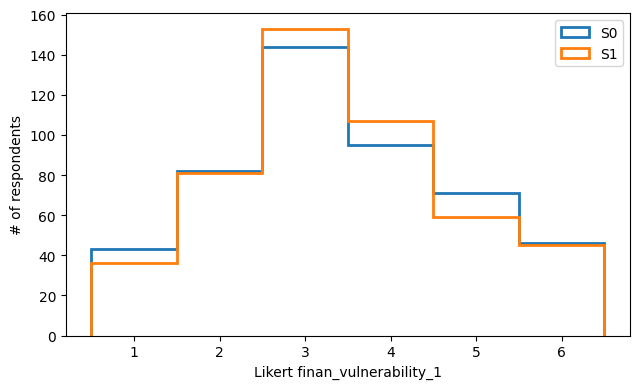

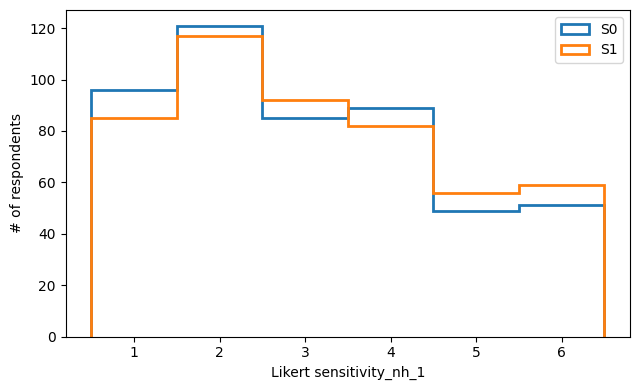

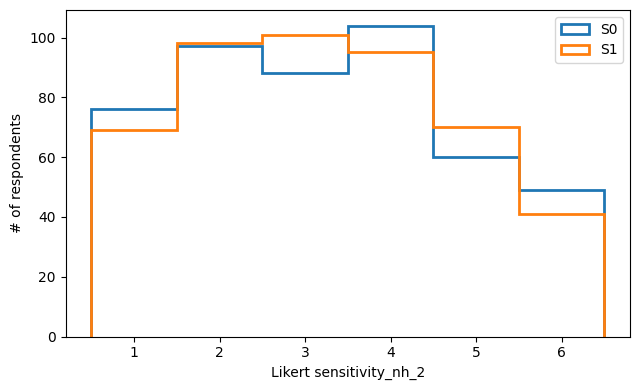

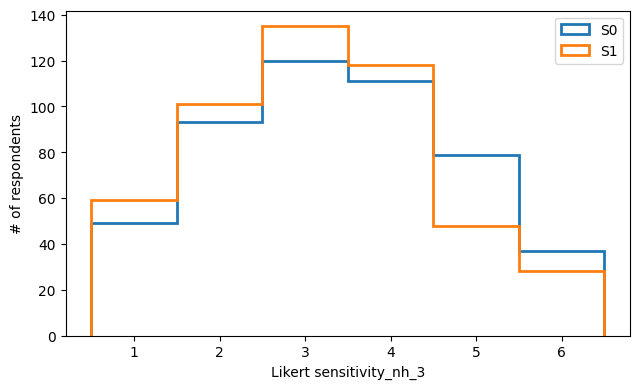

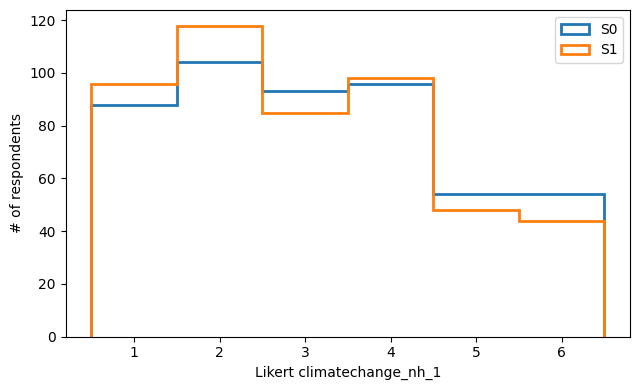

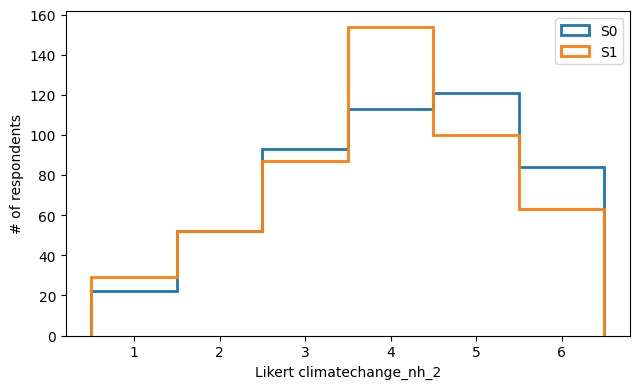

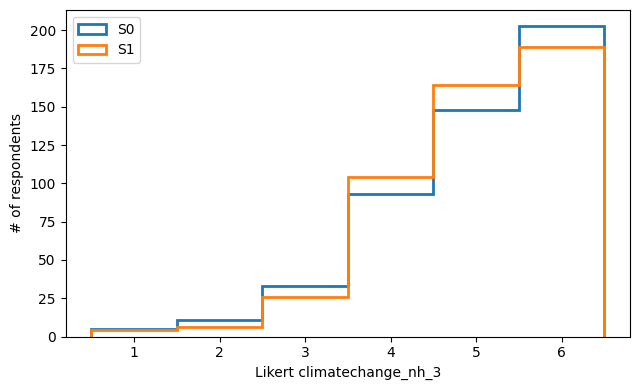

In [22]:
import matplotlib.pyplot as plt

def plot_s0_s1_histograms(df, items, s0_prefix="S0_", s1_prefix="S1_"):
    for item in items:
        c0, c1 = f"{s0_prefix}{item}", f"{s1_prefix}{item}"
        if c0 not in df.columns or c1 not in df.columns:
            continue

        m = df[c0].notna() & df[c1].notna()
        s0 = df.loc[m, c0]
        s1 = df.loc[m, c1]


        if len(s0) == 0 or len(s1) == 0:
            continue

        vmin = int(np.nanmin([s0.min(), s1.min()]))
        vmax = int(np.nanmax([s0.max(), s1.max()]))

        bins = np.arange(vmin - 0.5, vmax + 1.5, 1.0)  # diskrete "Histogramm"-Bins
        xticks = np.arange(vmin, vmax + 1, 1)

        plt.figure(figsize=(6.5, 4.0))
        plt.hist(s0, bins=bins, histtype="step", linewidth=2, label="S0")
        plt.hist(s1, bins=bins, histtype="step", linewidth=2, label="S1")
        plt.xticks(xticks)
        plt.xlabel(f"Likert {item}")
        plt.ylabel("# of respondents")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Aufruf:
plot_s0_s1_histograms(df, items)


In [10]:
# key = id_cols + ['nh_event', 'choice', 'option', 'attribute']

# dups = df_option.duplicated(key, keep=False)
# print('Duplikat-Zeilen für pivot:', dups.sum())

# # Zeig ein paar Beispiele
# df_option.loc[dups, key + ['var', 'value']].sort_values(key).head(30)

In [ ]:
# check IRR
# IRR survey pre blatten
IRR_S0_task1_choice = df_choice[(df_choice['task'] == 1)&(df_choice['nh_event'] == 0)][['respondent_id', 'nh_event','choice']]
IRR_S0_task6_choice = df_choice[(df_choice['task'] == 6)&(df_choice['nh_event'] == 0)][['respondent_id', 'nh_event','choice']]
IRR_S0_choice = pd.merge(IRR_S0_task1_choice, IRR_S0_task6_choice, on='respondent_id', suffixes=('_first', '_last'))
# dp.calc_IRR(IRR_S0_choice)

# IRR survey post blatten
IRR_S1_task1_choice = df_choice[(df_choice['task'] == 1)&(df_choice['nh_event'] == 1)][['respondent_id', 'nh_event','choice']]
IRR_S1_task9_choice = df_choice[(df_choice['task'] == 9)&(df_choice['nh_event'] == 1)][['respondent_id', 'nh_event','choice']]
IRR_S1_choice = pd.merge(IRR_S1_task1_choice, IRR_S1_task9_choice, on='respondent_id', suffixes=('_first', '_last'))
# dp.calc_IRR(IRR_S1_choice)

responses = IRR_S1_choice['respondent_id'].nunique()

# get inconsistent answers (options were switched in first and last task of surveys thus !=)
same_choice = IRR_S1_choice[(IRR_S1_choice['choice_first'] != IRR_S1_choice['choice_last'])]
num_same_choice = len(same_choice)

# get consistent answers
different_choice = IRR_S1_choice[(IRR_S1_choice['choice_first'] == IRR_S1_choice['choice_last'])]
num_different_choice = len(different_choice)

# calculate IRR
IRR_choice = (num_same_choice) / (num_same_choice + num_different_choice)
print(f'IRR: {IRR_choice}')

from scipy.stats import norm

sqer_IRR_choice = np.sqrt((IRR_choice * (1 - IRR_choice)) / responses)
z_crit = norm.ppf(0.975)  # 95% confidence interval
CI_plus = IRR_choice + (z_crit * sqer_IRR_choice)
CI_minus = IRR_choice - (z_crit * sqer_IRR_choice)

print(f'CI Plus: {CI_plus}')
print(f'CI Minus: {CI_minus}')


NameError: name 'df_choice' is not defined

In [26]:
# Krippendorff and Cohens K
from sklearn.metrics import cohen_kappa_score
import krippendorff

# inversion to account for inversion of options in conjoint
IRR_S0_choice['choice_last_invert'] = 3 - IRR_S0_choice['choice_last']

c_kappa = cohen_kappa_score(IRR_S0_choice['choice_first'], IRR_S0_choice['choice_last_invert'])

k_alpha = krippendorff.alpha(np.array([IRR_S0_choice['choice_first'].to_numpy(), IRR_S0_choice['choice_last_invert'].to_numpy()]))

print(f'Choice consitency - Cohens kappa: {c_kappa:.2f} and Krippendorffs alpha: {k_alpha:.2f}')


Choice consitency - Cohens kappa: 0.51 and Krippendorffs alpha: 0.51


Choice consitency - Cohens kappa: 0.51 and Krippendorffs alpha: 0.51

--> Moderate consistency... Should I remove those too?

0.51 doesn’t automatically mean the model is “bad.” It means respondents are not perfectly consistent—which is normal in conjoint/choice tasks because:
- choices are noisy,
- some pairs are near-indifferent,
- people use heuristics or get fatigued.

What I’d check next (quick, informative)
- Raw percent agreement (how often same choice repeated)
- Confusion matrix (how often flips happen and in which direction)
- Prevalence / imbalance (kappa/alpha can look lower if one option is chosen much more often)